In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
from scipy.interpolate import interp1d

%matplotlib inline
plt.rcParams.update({'font.size': 12})


In [2]:
def load_data(file):
    ds = xr.open_dataset(file)
    ds = ds.sel(Time=slice('2015-03-10', '2015-03-20'))
    df = ds.to_dataframe()
    df.reset_index(inplace=True)
    return df

filename = '/Users/gabriel/Desktop/DATA-LASP/cmo_dmin.nc'
df = load_data(filename)

In [3]:
def find_anomalous_values(df, column='X', std_factor=3, window=20):
    rolling_mean = df['X'].rolling(20).mean()
    rolling_std = df['X'].rolling(20).std()
    bad_values = (df['X'] < rolling_mean - std_factor * rolling_std) | (df['X'] > rolling_mean + std_factor * 
                                                                        rolling_std)
    df['bad_values'] = bad_values
    return df


def create_flag_col(df, column='X', flag_column='flag_column'):
    df[flag_column] = 0
    df[flag_column][df[column].isnull() == True] = 1
    return df


def flag_anomalies(df, flag_col='flag_column'):
    df[flag_col][df['bad_values'] == True] = 2
    return df

def interpolate_values(df, column='X'):
    df['fill_column'] = df['X'].interpolate(method='cubic')
    return df


In [4]:
def simple_plot(df, x_limits=[datetime.date(2015, 3, 11), datetime.date(2015, 3, 20)],
                s=.05):
    plt.scatter(df['Time'], df['X'], s=s)
    plt.xlim(x_limits)
    plt.xticks(rotation=120)
    plt.xlabel('Time')
    plt.ylabel('Geographic North- Units: nT')
    plt.show()
    

In [5]:
def interpolation_plot(df, column_x='Time', column_y='X', flag_col='flag_column', fill_col='fill_column', 
                       x_limits=[datetime.date(2015, 3, 11), datetime.date(2015, 3, 20)]):
    plt.figure(figsize=(12, 10))
    plt.plot(df[column_x], df[column_y], label=column_y, color='red')
    plt.scatter(df[column_x][df[flag_col] == 1], df[fill_col][df[flag_col] == 1],
                label='Interpolation', color='black', marker="x")
    plt.xlim(x_limits)
    plt.xlabel('Time')
    plt.ylabel('Geographic North- Units: nT')
    plt.xticks(rotation=120)
    plt.legend()
    plt.show()

In [6]:
def booshie_plot(df, column_x='Time', column_y='X', flag_col='flag_column', filled_col='fill_column',
               rolling_mean=df['X'].rolling(20).mean(), rolling_std=df['X'].rolling(20).std(),
               x_limits=[datetime.date(2015, 3, 11), datetime.date(2015, 3, 20)], std_factor=3):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    ax[0].plot(df[column_x], df[column_y], label=column_y, color='red')
    #ax[0].plot(df[column_x], rolling_mean, color='orange', label='Rolling Mean')
    
    
    ax[0].fill_between(df[column_x], rolling_mean - std_factor * rolling_std, 
                       rolling_mean + std_factor * rolling_std, alpha=0.75, color='orange', 
                       label='STD threshold')
    
    ax[0].scatter(df[column_x][df[flag_col] == 1], df[filled_col][df[flag_col] == 1], 
                  label='Interpolation', s=1)
    ax[0].scatter(df[column_x][df[flag_col] == 2], df[filled_col][df[flag_col] == 2], 
                  label='Anomalies', color='black', marker='x')
    

    ax[1].plot(df[column_x], rolling_std, color='orange', label='Rolling Standard Deviation')

    ax[0].get_shared_x_axes().join(ax[0], ax[1])
    ax[0].set_xticklabels([])

    plt.xlim(x_limits)
    plt.xlabel('Time')
    plt.ylabel('Geographic North- Units: nT')
    plt.xticks(rotation=120)
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [7]:
df = find_anomalous_values(df)


In [8]:
df = create_flag_col(df)

/var/folders/nj/1lttj3_x16ldy51707n65swm0000gn/T/ipykernel_6920/3550250470.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[flag_column][df[column].isnull() == True] = 1


In [9]:
df = flag_anomalies(df)

/var/folders/nj/1lttj3_x16ldy51707n65swm0000gn/T/ipykernel_6920/3550250470.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[flag_col][df['bad_values'] == True] = 2


In [10]:
df = interpolate_values(df)

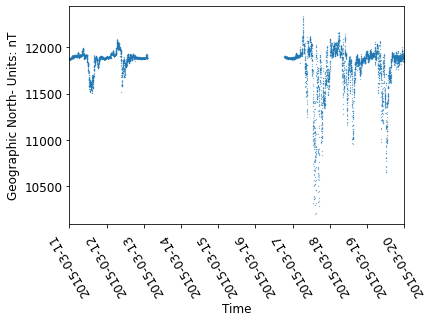

In [11]:
simple_plot(df)

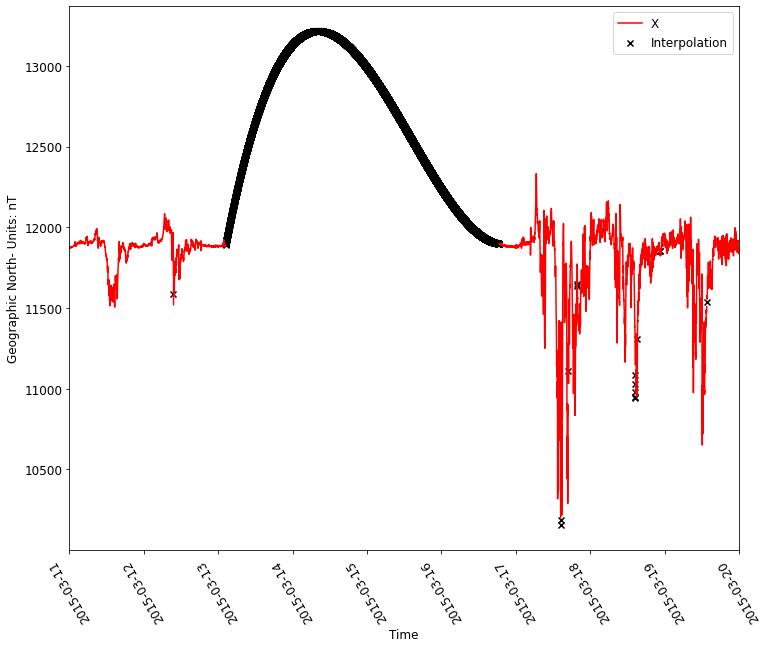

In [12]:
interpolation_plot(df)

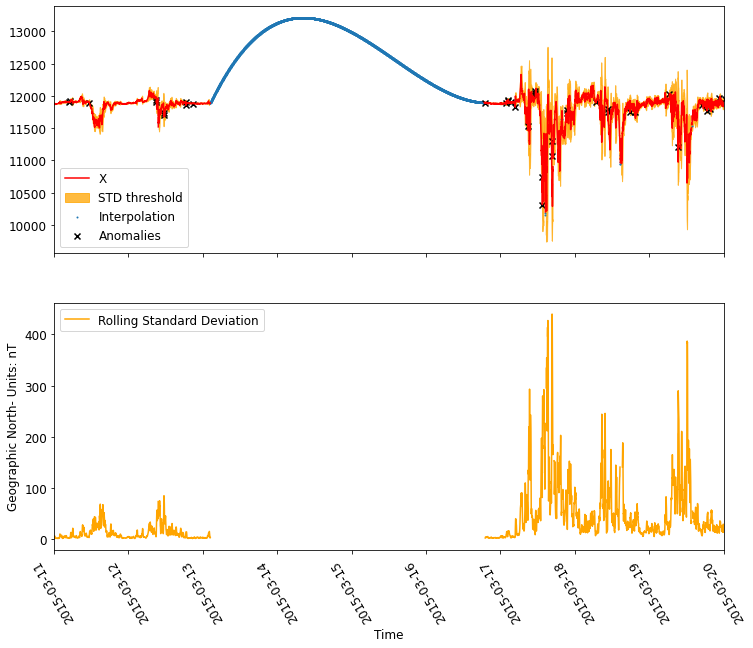

In [13]:
booshie_plot(df)